In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

inputFile="data/team-results.csv"

In [2]:
df=pd.read_csv(inputFile)
df.head()

,ATL,BKN,BOS,CHA,CHI,CLE,DAL,DEN,DET,GSW,...,OKC,ORL,PHI,PHX,POR,SAC,SAS,TOR,UTA,WAS
0,-1,-1,-1,-1,1,-1,1,-1,-1,-1,...,-1,1,1,-1,-1,1,-1,1,1,-1
1,1,1,-1,1,1,-1,1,-1,-1,-1,...,1,-1,-1,-1,1,1,1,-1,-1,1
2,-1,-1,1,1,1,-1,1,-1,-1,1,...,1,1,-1,1,-1,1,1,-1,1,-1
3,1,-1,-1,-1,1,-1,1,-1,1,-1,...,1,1,1,-1,-1,1,1,-1,1,1
4,1,1,-1,-1,1,-1,-1,-1,1,1,...,-1,1,-1,1,1,1,1,-1,1,-1


In [3]:
shuffles=1000
limsMA=[]
ma=30

limacfs=np.zeros((shuffles,len(df.columns),819+ma))
for i in range(shuffles):
    sdf=df.copy()
    sdf.apply(np.random.shuffle,axis=0);
    for j,team in enumerate(df.columns):
        limacfs[i,j]=np.array([sdf[team].autocorr(k) for k in np.arange(1,820+ma,1)])
del i,j,team, sdf, shuffles
lims=[np.percentile(limacfs[:,i],[2.5,97.5],axis=0).T for i in range(df.shape[1])]

for l in lims:
    cumsum=np.cumsum(l,axis=0)
    limsMA+=[(cumsum[ma:]-cumsum[:-ma])/ma,]
del l, cumsum

In [4]:
def add_subplot_axes(ax,rect,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height],facecolor=axisbg)
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

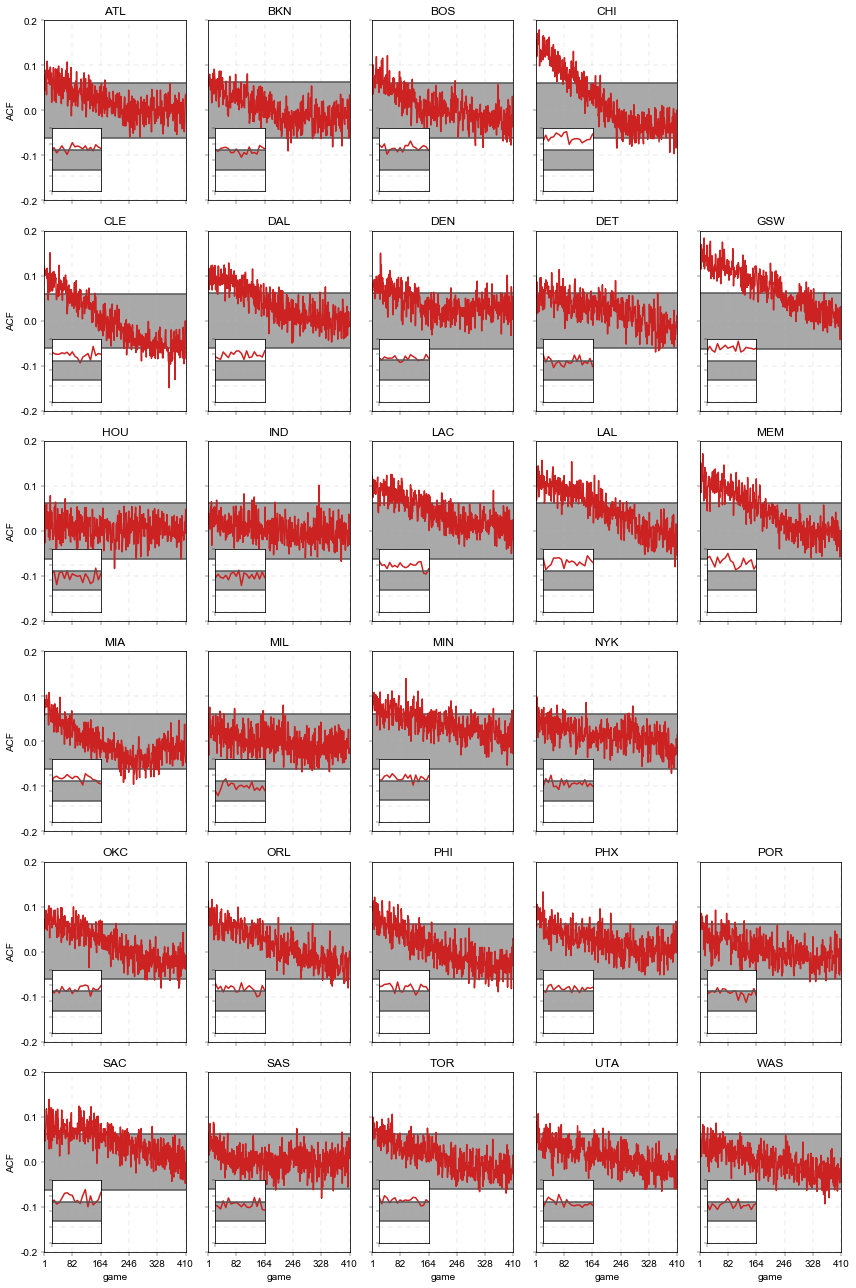

In [5]:
X=np.arange(1,411,1)
X2=np.arange(1,21,1)
xticks=np.arange(0,np.max(X)+1,82)
yticks=np.arange(-0.2,0.25,0.1)
xticks[0]=1
rows=5
cols=6
with PdfPages("figs/correlation-shuffle-total.pdf") as pdfFile:
    axes=[]
    fig=plt.figure(figsize=(12,18))
    for i,team in enumerate(df.columns):
        if team in ["NOP","CHA"]:
            axes.append(None)
            continue
        if team in ["CHI","NYK"]:
            cax=fig.add_subplot(cols,rows,i)
        else:
            cax=fig.add_subplot(cols,rows,i+1)
        axes.append(cax)
        cax.grid(linestyle="--",dashes=(15,15),c="#bbbbbb",lw=0.3)
        cax.get_yaxis().set_tick_params(direction='out')
        cax.get_xaxis().set_tick_params(direction='out')
        cax.set_yticks(yticks)
        cax.set_xticks(xticks)
        cax.set_title(team)
        cax.set_ylim([np.min(yticks),np.max(yticks)])
        cax.set_xlim([np.min(X),np.max(X)])
        if (i % rows)>0:
            cax.set_yticklabels([])
        else:
            cax.set_ylabel("ACF")
            cax.set_yticklabels(["{:.1f}".format(t) for t in yticks])
        if i<rows*(cols-1):
            cax.set_xticklabels([])
        else:
            cax.set_xlabel("game")
            cax.set_xticklabels(["{:d}".format(t) for t in xticks])
    plt.tight_layout()
    for i,team in enumerate(df.columns):
        if team in ["NOP","CHA"]:
            continue
        lma=limsMA[i]
        lma[:,0]=lma[-1,0]
        lma[:,1]=lma[-1,1]
        cax=axes[i]
        acf=np.array([df[team].autocorr(k) for k in X])
        #print(team,1-np.sum((lims[i][:len(acf),0]<acf) & (acf<lims[i][:len(acf),1]))/len(acf))
        cax.plot(X,lma[:len(X),0],
                 X,lma[:len(X),1],color='#555555')
        cax.fill_between(X,
                         lma[:len(X),0],
                         lma[:len(X),1],facecolor='#555555',alpha=0.5)
        cax.plot(X,acf,'#cc2222')

        scax=add_subplot_axes(cax,[0.05,0.05,0.35,0.35])
        scax.grid(linestyle="--",dashes=(15,15),c="#bbbbbb",lw=0.3)
        scax.get_yaxis().set_tick_params(direction='out')
        scax.get_xaxis().set_tick_params(direction='out')
        scax.set_yticks(yticks)
        scax.set_xticks(xticks)
        scax.set_ylim([np.min(yticks),np.max(yticks)])
        scax.set_xlim([np.min(X2),np.max(X2)])
        scax.set_xticklabels([])
        scax.set_yticklabels([])

        scax.plot(X2,acf[:len(X2)],'#cc2222')
        scax.plot(X2,lma[:len(X2),0],
                  X2,lma[:len(X2),1],color='#555555')
        scax.fill_between(X2,
                          lma[:len(X2),0],
                          lma[:len(X2),1],facecolor='#555555',alpha=0.5)

    plt.show()
    pdfFile.savefig(fig)